In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import pandas_datareader.data as reader
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.keras.models import Sequential

In [9]:
end = dt.datetime.now()
start = dt.date(end.year - 8, end.month, end.day)
cryptolist = ['AAVE-USD', 'BNB-USD', 'BTC-USD', 'LINK-USD','ADA-USD','ETH-USD', 'SOL-USD', 'USDT-USD', 'UNI1-USD']
df = reader.get_data_yahoo(cryptolist, start, end)['Adj Close']

end1 = dt.date(end.year - 1, end.month, end.day) #1 years back

##changing date accordingly if early half vs late half of the year
if (end.month <=6):
    end2 = dt.date(end.year-1, 6+end.month, end.day) #6 months back
else:
    end2 = dt.date(end.year, end.month-6, end.day)
    
##setting start date to 3 years before the end dates
start1 = dt.date(end1.year - 3, end.month, end.day) #3 years before end1

#final start and end for future prediction
startfinal = dt.date(end.year-3, end.month, end.day) # 3 years before now
endfinal = dt.date(end.year, end.month, end.day) #now

##getting 3 datasets, df1 and df2 for backtest prediction, while df is for future prediction
df1 = reader.get_data_yahoo(cryptolist, start1, end1)['Adj Close']
df2 = reader.get_data_yahoo(cryptolist, start1, end2)['Adj Close']
df = reader.get_data_yahoo(cryptolist, startfinal, endfinal)['Adj Close']


In [10]:
##resetting the indexes of the dataset
##run this ONLY ONCE

df1 = df1.reset_index()
df2 = df2.reset_index()
df = df.reset_index()

In [11]:
df1[['ds', 'y']] = df1[['Date', 'BTC-USD']]

In [12]:
df2[['ds', 'y']] = df2[['Date', 'BTC-USD']]
df[['ds', 'y']] = df1[['Date', 'BTC-USD']]

In [25]:
##scale all the data from 0 to 1
def preparation(data):
    crypto_currency = data.iloc[0][1]
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data['BTC-USD'].values.reshape(-1,1))
    days = 30
    prediction_day = 30
    x_train, y_train = [], []
    for x in range(days,len(data)-prediction_day):
        x_train.append(scaled_data[x-days:x,0])
        y_train.append(scaled_data[x+prediction_day,0])
        
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    
    ##neural network
    model = Sequential()
    model.add(LSTM(units=50, return_sequences= True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units =50, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units =1))
    model.compile(optimizer='adam',loss = 'mean_squared_error')
    model.fit(x_train, y_train, epochs=25, batch_size = 32)
    #testing
    test_data = data.iloc[int(len(data)*(3/4)):-1]
    actual_prices = test_data['BTC-USD'].values
    total_dataset = pd.concat((data['BTC-USD'],test_data['BTC-USD']),axis=0)
    model_inputs = total_dataset[len(total_dataset)-len(test_data)-days:].values
    model_inputs = model_inputs.reshape(-1,1)
    model_inputs = scaler.fit_transform(model_inputs)
    x_test = []

    for x in range(days, len(model_inputs)):
        x_test.append(model_inputs[x-days:x,0])


    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

    predict_prices = model.predict(x_test)
    predict_prices = scaler.inverse_transform(predict_prices)
    plt.figure(figsize = (25,10))
    plt.plot(actual_prices, color = 'black', label = 'Actual Prices')
    plt.plot(predict_prices, color = 'blue', label = 'Prediction Prices')
    plt.title('BTC price prediction')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend(loc='upper left')
    plt.show()
    ##to predict the next month
    real_data = [model_inputs[len(model_inputs) - days:len(model_inputs) +1,0]]
    real_data = np.array(real_data)
    real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))
    prediction_value = model.predict(real_data)
    prediction_value = scaler.inverse_transform(prediction_value)
    return (prediction_value)

Epoch 1/25
33/33 [==============================] - 89s 41ms/step - loss: 0.0205
Epoch 2/25
33/33 [==============================] - 1s 39ms/step - loss: 0.0051
Epoch 3/25
33/33 [==============================] - 1s 37ms/step - loss: 0.0037
Epoch 4/25
33/33 [==============================] - 1s 38ms/step - loss: 0.0042
Epoch 5/25
33/33 [==============================] - 1s 38ms/step - loss: 0.0037
Epoch 6/25
33/33 [==============================] - 1s 38ms/step - loss: 0.0038
Epoch 7/25
33/33 [==============================] - 1s 37ms/step - loss: 0.0036
Epoch 8/25
33/33 [==============================] - 1s 36ms/step - loss: 0.0033
Epoch 9/25
33/33 [==============================] - 1s 37ms/step - loss: 0.0033
Epoch 10/25
33/33 [==============================] - 1s 37ms/step - loss: 0.0036
Epoch 11/25
33/33 [==============================] - 1s 36ms/step - loss: 0.0027
Epoch 12/25
33/33 [==============================] - 1s 36ms/step - loss: 0.0025
Epoch 13/25
33/33 [=================

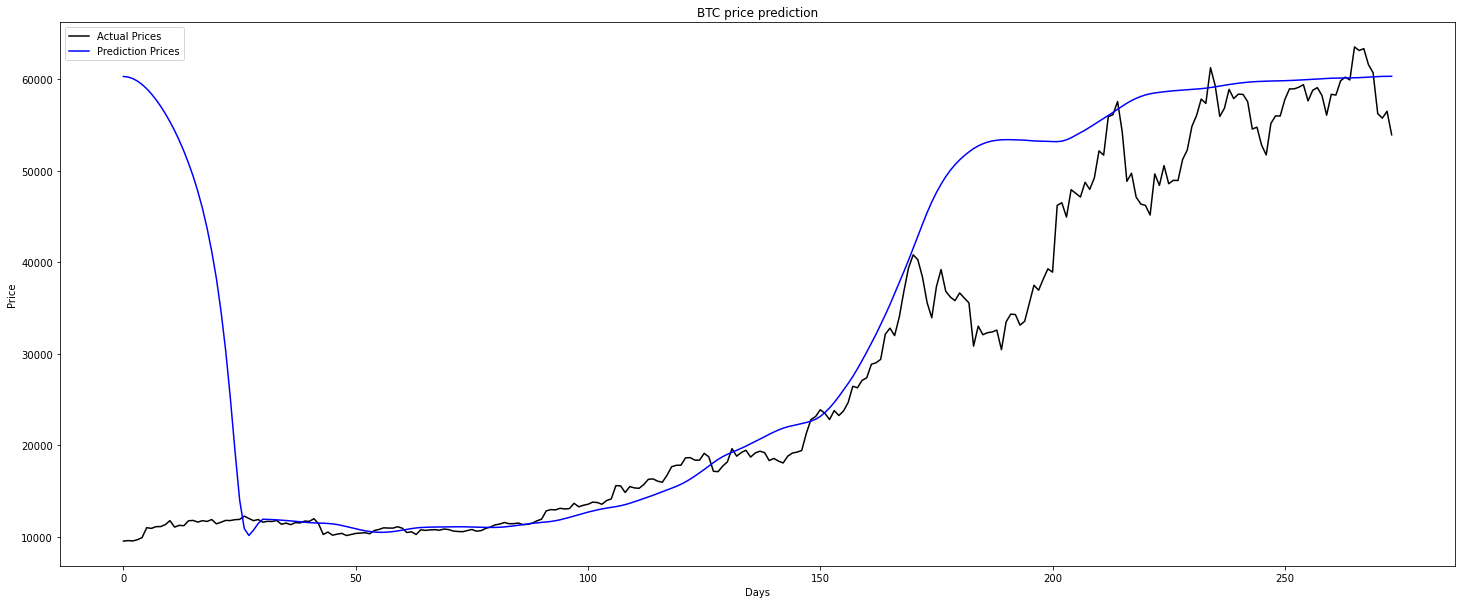

array([[60290.082]], dtype=float32)

In [26]:
preparation(df1)
#1 year

Epoch 1/25
39/39 [==============================] - 8s 36ms/step - loss: 0.0258
Epoch 2/25
39/39 [==============================] - 1s 36ms/step - loss: 0.0106
Epoch 3/25
39/39 [==============================] - 1s 35ms/step - loss: 0.0108
Epoch 4/25
39/39 [==============================] - 1s 36ms/step - loss: 0.0094
Epoch 5/25
39/39 [==============================] - 1s 38ms/step - loss: 0.0084
Epoch 6/25
39/39 [==============================] - 1s 35ms/step - loss: 0.0077
Epoch 7/25
39/39 [==============================] - 1s 36ms/step - loss: 0.0068
Epoch 8/25
39/39 [==============================] - 2s 39ms/step - loss: 0.0079
Epoch 9/25
39/39 [==============================] - 1s 35ms/step - loss: 0.0066
Epoch 10/25
39/39 [==============================] - 1s 37ms/step - loss: 0.0071
Epoch 11/25
39/39 [==============================] - 2s 40ms/step - loss: 0.0063
Epoch 12/25
39/39 [==============================] - 1s 34ms/step - loss: 0.0065
Epoch 13/25
39/39 [==================

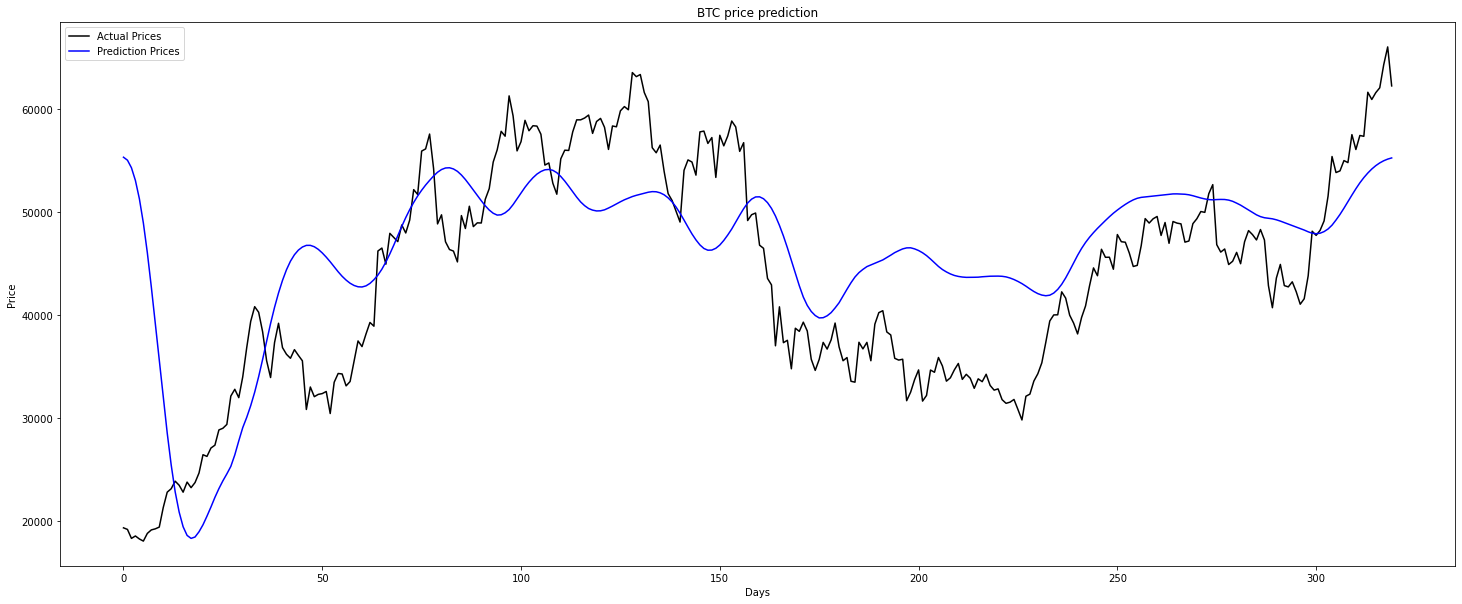

array([[55287.535]], dtype=float32)

In [27]:
preparation(df2)
#6 month

Epoch 1/25
33/33 [==============================] - 7s 35ms/step - loss: 0.0441
Epoch 2/25
33/33 [==============================] - 1s 36ms/step - loss: 0.0160
Epoch 3/25
33/33 [==============================] - 1s 36ms/step - loss: 0.0143
Epoch 4/25
33/33 [==============================] - 1s 35ms/step - loss: 0.0119
Epoch 5/25
33/33 [==============================] - 1s 35ms/step - loss: 0.0117
Epoch 6/25
33/33 [==============================] - 1s 37ms/step - loss: 0.0117
Epoch 7/25
33/33 [==============================] - 1s 37ms/step - loss: 0.0110
Epoch 8/25
33/33 [==============================] - 1s 40ms/step - loss: 0.0127
Epoch 9/25
33/33 [==============================] - 1s 37ms/step - loss: 0.0116
Epoch 10/25
33/33 [==============================] - 1s 35ms/step - loss: 0.0107
Epoch 11/25
33/33 [==============================] - 1s 33ms/step - loss: 0.0097
Epoch 12/25
33/33 [==============================] - 1s 35ms/step - loss: 0.0103
Epoch 13/25
33/33 [==================

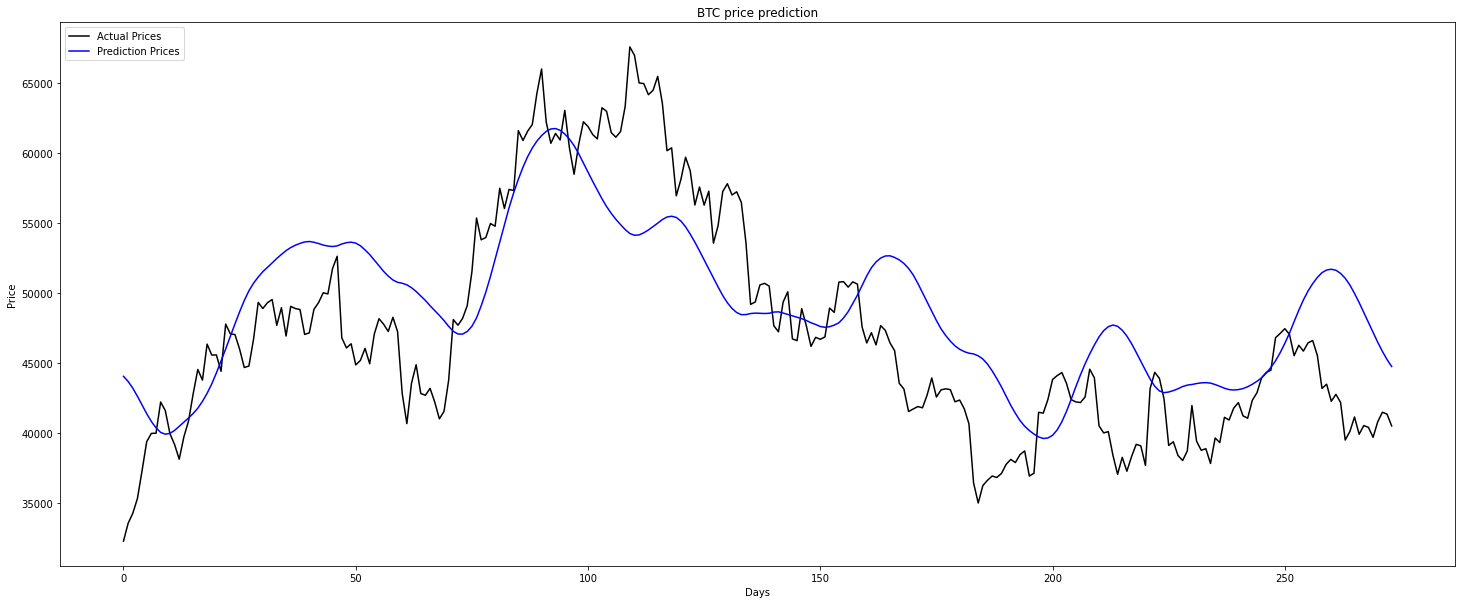

array([[44376.926]], dtype=float32)

In [28]:
preparation(df)
#current